### 1. Carga de datos y entrenamiento del modelo

En esta sección cargo los tweets etiquetados como *Apruebo* y *Rechazo* desde archivos CSV y los uno en un solo conjunto de datos.
Luego transformo el texto en una representación numérica usando **TF-IDF**, que asigna un peso a cada palabra según su importancia en el tweet.

Con esos vectores entreno un modelo de **Regresión Logística** para clasificar si un tweet es de Apruebo (1) o Rechazo (0).  
Finalmente, evalúo el modelo con un **reporte de clasificación** y una **matriz de confusión**, que me permiten ver qué tan bien distingue entre ambas clases.


Total datos: 853 | Apruebo: 751 | Rechazo: 102

=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

     Rechazo       0.40      0.48      0.44        29
     Apruebo       0.93      0.91      0.92       227

    accuracy                           0.86       256
   macro avg       0.67      0.70      0.68       256
weighted avg       0.87      0.86      0.87       256



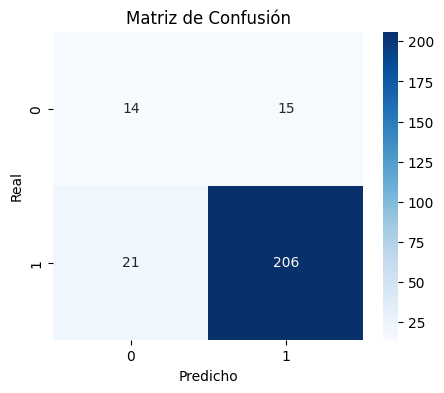

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

try:
    # Carga de los CSV temáticos como "ground truth"
    df_apruebo = pd.read_csv('../data/tweets_csv/apruebo.csv')
    df_rechazo = pd.read_csv('../data/tweets_csv/rechazo_campaña.csv')
    
    # Etiquetas: 1 = Apruebo, 0 = Rechazo
    df_apruebo['label'] = 1
    df_rechazo['label'] = 0
    
    # union de todo en un solo dataset
    df = pd.concat([df_apruebo, df_rechazo], ignore_index=True).drop_duplicates(subset=['Tweet Content'])
    df['Tweet Content'] = df['Tweet Content'].fillna('')
    
    print(f"Total datos: {len(df)} | Apruebo: {sum(df.label==1)} | Rechazo: {sum(df.label==0)}")
except:
    print("Error cargando archivos. Verifica que estén en la carpeta correcta.")

# Las stopwords para limpiar el texto y evitar que el modelo aprenda palabras obvias
stopwords = ['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'se', 'es', 'un', 'con', 'las', 'su', 'al', 'lo', 't', 'co', 'https', 'http'] 
#las etiquetas obvias para forzar al modelo a aprender contexto
stopwords += ['apruebo', 'rechazo', '#apruebo', '#rechazo']

tfidf = TfidfVectorizer(
    max_features=3000, 
    stop_words=stopwords,
    ngram_range=(1, 2),
    min_df=3
)

X = tfidf.fit_transform(df['Tweet Content'])
y = df['label']

# Usamos class_weight='balanced' para ayudar con el desbalance de clases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred, target_names=['Rechazo', 'Apruebo']))

# Matriz de Confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()



### 2. Análisis no supervisado con PCA

Aquí aplico **PCA (Análisis de Componentes Principales)** para reducir la alta dimensionalidad de los vectores TF-IDF a solo 2 dimensiones (PC1 y PC2).

El objetivo es **visualizar** si los tweets etiquetados como *Apruebo* y *Rechazo* tienden a agruparse de forma distinta en el espacio de características.

Si en el gráfico los puntos de Apruebo y Rechazo quedan relativamente separados, eso sugiere que el modelo tiene información suficiente para distinguir ambas clases.  
Si se mezclan mucho, el problema es más difícil y el modelo tendrá más errores.


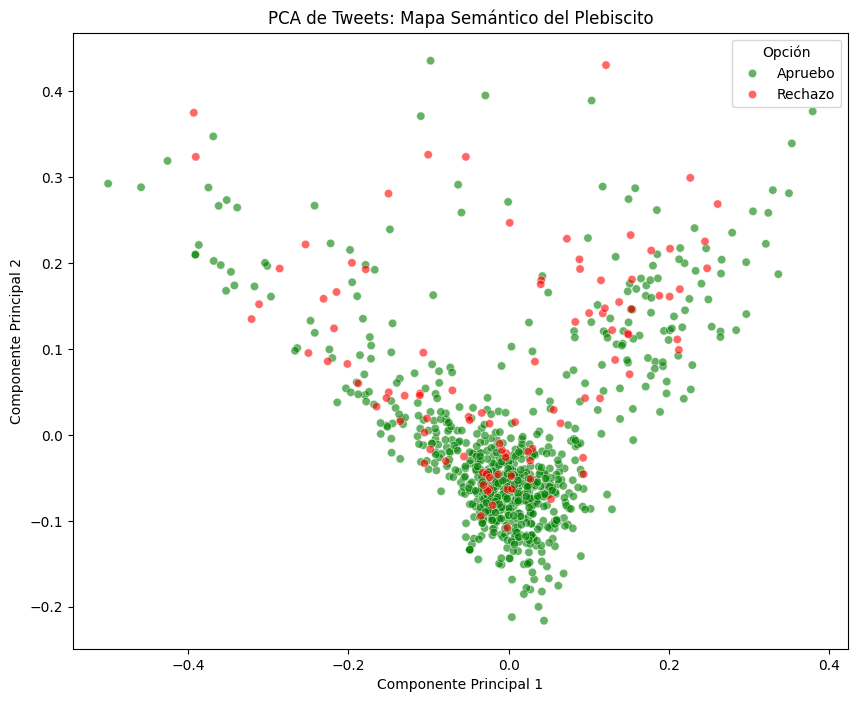

In [13]:
# 4. ANÁLISIS NO SUPERVISADO (PCA)
# Reducimos la dimensionalidad para ver si los grupos se separan visualmente
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Opción'] = y.map({1: 'Apruebo', 0: 'Rechazo'})

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Opción', data=df_pca, palette={'Apruebo': 'green', 'Rechazo': 'red'}, alpha=0.6)
plt.title('PCA de Tweets: Mapa Semántico del Plebiscito')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

### 3. Distribución de opiniones en Twitter según el modelo

Ahora aplico el modelo entrenado a **todos los tweets** disponibles.  
Para cada tweet, el modelo predice si es de Apruebo o de Rechazo, y esa predicción se guarda en la columna `prediccion_modelo`.

Luego calculo el **porcentaje de tweets** clasificados como Apruebo y como Rechazo.  
Esta distribución NO es un resultado oficial de votación, sino una estimación de **cómo se ve la conversación en Twitter** según nuestro modelo.

In [20]:
X_total = tfidf.transform(df['Tweet Content'])
df['prediccion_modelo'] = model.predict(X_total) # Aquí se crea la columna

#CALCULAR PORCENTAJES
conteo_predicciones = df['prediccion_modelo'].value_counts(normalize=True)

porcentaje_apruebo_twitter = conteo_predicciones.get(1, 0) * 100
porcentaje_rechazo_twitter = conteo_predicciones.get(0, 0) * 100

print("-" * 40)
print("RESULTADOS DE LA PREDICCIÓN EN TWITTER")
print("-" * 40)
print(f"Apruebo (Predicho): {porcentaje_apruebo_twitter:.2f}%")
print(f"Rechazo (Predicho): {porcentaje_rechazo_twitter:.2f}%")
print("-" * 40)



----------------------------------------
RESULTADOS DE LA PREDICCIÓN EN TWITTER
----------------------------------------
Apruebo (Predicho): 83.24%
Rechazo (Predicho): 16.76%
----------------------------------------


### 4. Resultados oficiales del SERVEL

En esta sección cargo los resultados oficiales del plebiscito desde el archivo `servel_total.csv`.  
Filtro los votos de **APRUEBO** y **RECHAZO**, calculo el total de votos válidos y obtengo el porcentaje oficial de cada opción.

Estos porcentajes representan la **realidad electoral**, es decir, lo que realmente ocurrió en la votación, y serán la base para comparar con lo observado en Twitter.


In [21]:
#ahora voy a evaluar el porcentaje de los votos dados por el servel
df_servel = pd.read_csv("../data/raw/servel_total.csv")

# Filtrar los votos de APRUEBO y RECHAZO
# Usamos la columna 'Total' para el resultado oficial final
votos_apruebo = df_servel[df_servel["Opción Constitución Política"] == "APRUEBO"]["Total"].values[0]
votos_rechazo = df_servel[df_servel["Opción Constitución Política"] == "RECHAZO"]["Total"].values[0]

# Calcular el total de votos válidamente emitidos (Apruebo + Rechazo)
total_validos = votos_apruebo + votos_rechazo

# Calcular porcentajes
porcentaje_apruebo = (votos_apruebo / total_validos) * 100
porcentaje_rechazo = (votos_rechazo / total_validos) * 100

print(f"Resultados Oficiales (Votos Válidos):")
print(f"Apruebo: {porcentaje_apruebo:.2f}% ({votos_apruebo:,.0f} votos)")
print(f"Rechazo: {porcentaje_rechazo:.2f}% ({votos_rechazo:,.0f} votos)")

Resultados Oficiales (Votos Válidos):
Apruebo: 78.31% (5,899,683 votos)
Rechazo: 21.69% (1,634,506 votos)


### 5. Comparación entre Twitter y resultados oficiales

Finalmente, comparo el porcentaje de tweets a favor del Apruebo (`porcentaje_apruebo_twitter`) con el porcentaje oficial de Apruebo en el plebiscito (78,31%).

La diferencia se expresa en **puntos porcentuales**.  
Un valor positivo indica que en Twitter el Apruebo aparece sobrerrepresentado respecto a la votación real; un valor negativo indica que en Twitter aparece subrepresentado.

Esta comparación permite discutir hasta qué punto la conversación en Twitter refleja o no el resultado del plebiscito.
El objetivo acá no es "predecir una elección con Twitter", sino ver la brecha entre las redes sociales y la realidad electoral

In [22]:
# 4. Comparación con SERVEL
print(f"Diferencia Apruebo (Twitter vs Realidad): {porcentaje_apruebo_twitter - 78.31:.2f} puntos")

Diferencia Apruebo (Twitter vs Realidad): 4.93 puntos
